In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import keras_core
from keras_core import layers
from keras_core import optimizers
import keras_mdn_layer as mdn

from mixture_density_nets import MDN, MDDistribution

Using TensorFlow backend





### Data import and pre-process

In [11]:
filename = 'D:/OneDrive - TU Eindhoven/Quartile_4/4AI000_Machine learning for Multi-physics modelling and design/Materials_for_ML_assignment_2024/H2_IsoThermalWalls_Sw_0/H2_Vel_MD_Sw_0_B300_Th_300.txt'
names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel)


x = df_trans_vel.loc[:, ].values
x_norm = StandardScaler().fit_transform(x) # normalizing the features

# Creating Dataframe of normalized values
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel)

x = df_trans_vel_norm[['v_x_in']].to_numpy()
y = df_trans_vel_norm[['v_x_out']].to_numpy()

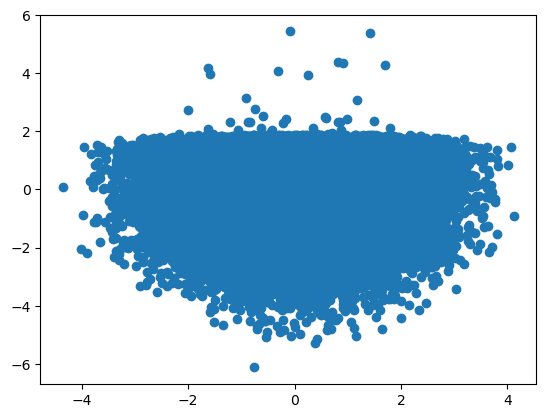

In [12]:
plt.scatter(x, y)
plt.show()

In [13]:
N_HIDDEN = 15
N_MIXES = 10


mdn_network = keras_core.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        mdn.MDN(1, N_MIXES),
    ]
)

model = keras.Sequential()
model.add(layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(layers.Dense(N_HIDDEN, activation='relu'))
model.add()
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

ValueError: Unrecognized keyword arguments passed to Dense: {'batch_input_shape': (None, 1)}

In [ ]:
N_HIDDEN = 128

OUTPUT_DIMS = 1
N_MIXES = 20

mdn_network = keras_core.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

In [ ]:
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(
            y_pred,
            [-1, (2 * num_mixes * output_dim) + num_mixes],
            name="reshape_ypreds",
        )
        y_true = tf.reshape(y_true, [-1, output_dim], name="reshape_ytrue")
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            num_or_size_splits=[
                num_mixes * output_dim,
                num_mixes * output_dim,
                num_mixes,
            ],
            axis=-1,
            name="mdn_coef_split",
        )
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    return mdn_loss_func


mdn_network.compile(loss=get_mixture_loss_func(OUTPUT_DIMS, N_MIXES), optimizer="adam")

In [ ]:
mdn_network.fit(
    x,
    y,
    epochs=100,
    batch_size=128,
    validation_split=0.15,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100


820/820 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.3647 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 2/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.3657 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 3/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.3648 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 4/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.3620 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 5/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3653 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 6/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3672 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 7/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3633 - val_loss: 1.3625 - learning_rate: 1.0000e-05
Epoch 8/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.3650 - val_loss: 1.3625 - learning_rate: 1.0000e-06
Epoch 9/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3661 - val_loss: 1.3625 - lea

In [ ]:
y_pred_mixture = mdn_network.predict(x)
print(y_pred_mixture.shape)
y_pred_mixture

3855/3855 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
(123351, 60)


array([[-0.4100366 ,  0.88863873,  1.6416752 , ..., -0.21671265,
         0.39885893, -0.14806518],
       [-0.3922266 ,  0.8856042 ,  1.6393962 , ..., -0.21777795,
         0.39031598, -0.12757964],
       [-0.3846447 ,  0.91105175,  1.6686616 , ..., -0.23123568,
         0.37236318, -0.10797444],
       ...,
       [-0.38832042,  0.8929246 ,  1.6535839 , ..., -0.22258157,
         0.38484877, -0.11828597],
       [-0.3875744 ,  0.90983355,  1.6711867 , ..., -0.23233092,
         0.37426266, -0.1089329 ],
       [-0.38962328,  0.8976933 ,  1.660653  , ..., -0.22745992,
         0.38215098, -0.11590518]], dtype=float32)

In [ ]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [ ]:
# Sample from the predicted distributions
y_samples = np.apply_along_axis(
    sample_from_output, 1, y_pred_mixture, 1, N_MIXES, temp=1.0
)
y_samples

array([[[-0.39825334]],

       [[-0.8229388 ]],

       [[-1.67948031]],

       ...,

       [[ 1.26058743]],

       [[-2.66420341]],

       [[-0.34084967]]])

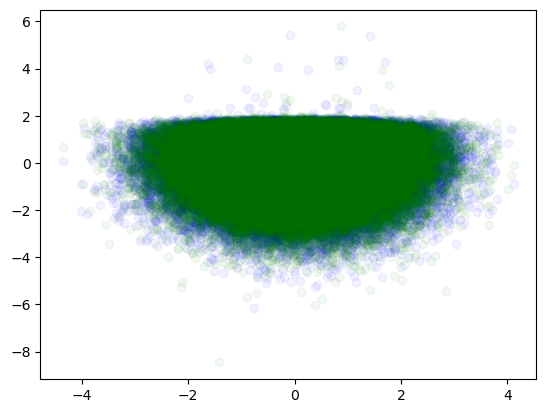

In [ ]:
plt.scatter(x, y, alpha=0.05, color="blue", label="Ground Truth")
plt.scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
plt.show()

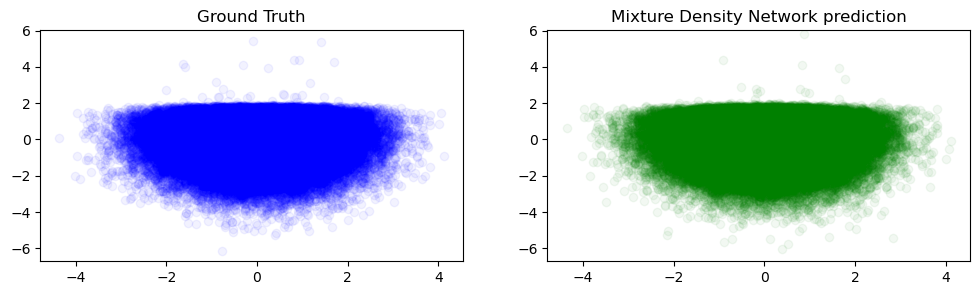

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(12)
axs[0].set_title("Ground Truth")
axs[0].scatter(x, y, alpha=0.05, color="blue")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[1].scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
axs[1].set_title("Mixture Density Network prediction")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
plt.show()